# Jawaban 1

# Libraries

In [1]:
from skimage import feature
from imutils import paths
import numpy as np
import argparse
import cv2 as cv
import os
import pandas as pd
from google.colab.patches import cv2_imshow

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

from imutils import build_montages

# Function dan Load data

In [2]:
def preprocess(image, image_size=128):
		image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) # Ubah mehjadi grayscale
		image = cv.resize(image, (image_size, image_size)) # Resize gambar menjadi suatu ukuran (default = 128)

		image = cv.threshold(image, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1] # Melakukan thresholding dan mengambil hasil gambar thresholding

		return image

In [3]:
def quantify_image_hog(image): # Histogram of Oriented Gradient features
	features = feature.hog(image, orientations=9, pixels_per_cell=(10, 10), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1")

	return features

In [4]:
def quantify_image_lbp(image): # Local Binary Pattern features
  features = feature.local_binary_pattern(image, 24, 8, method="uniform")

  (hist, _) = np.histogram(features.flatten(), bins=np.arange(0, 27), range=(0, 26))

  hist = hist.astype("float")
  hist /= (hist.sum() + 1e-7)

  return hist

In [5]:
def load_split(path, image_size=200, extraction_method='hog'):
	image_paths = list(paths.list_images(path))
	data = []
	labels = []

	for image_path in image_paths:
		label = image_path.split(os.path.sep)[-2]

		image = cv.imread(image_path)
		image = preprocess(image, image_size=image_size)
		
		if extraction_method == 'hog':
			features = quantify_image_hog(image)
		elif extraction_method == 'lbp':
			features = quantify_image_lbp(image)

		data.append(features)
		labels.append(label)

	return (np.array(data), np.array(labels))

In [6]:
dataset_dir = '/content/drive/My Drive/BCML/CV/wave'

trainingPath = os.path.join(dataset_dir, "training")
testingPath = os.path.join(dataset_dir, "testing")

# Size 128, Method Hog

In [7]:
resize_image_size = 128
extraction_method = 'hog'

In [8]:
(feature_train, label_train) = load_split(trainingPath, image_size=resize_image_size, extraction_method=extraction_method)
(feature_test, label_test) = load_split(testingPath, image_size=resize_image_size, extraction_method=extraction_method)

print("Data loaded!")

Data loaded!


In [9]:
le = LabelEncoder()
label_train = le.fit_transform(label_train)
label_test = le.transform(label_test)

In [10]:
label_train

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [11]:
label_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

**Logistic Regression**

In [12]:
logreg = LogisticRegression()
logreg.fit(feature_train, label_train)
predictions = logreg.predict(feature_test)

classification_report(label_test, predictions)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(feature_test, label_test))) # .score() -> Accuracy
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

Accuracy of logistic regression classifier on test set: 0.67
F1 0.6651785714285714
Precision 0.6696832579185521
Recall 0.6666666666666666


**LinearSVC**

In [13]:
classifier_lsvc = LinearSVC()
classifier_lsvc.fit(feature_train, label_train)
predictions = classifier_lsvc.predict(feature_test)

classification_report(label_test, predictions)
print('Accuracy of LinearSVC on test set: {:.2f}'.format(classifier_lsvc.score(feature_test, label_test)))
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

Accuracy of LinearSVC on test set: 0.67
F1 0.6666666666666666
Precision 0.6666666666666666
Recall 0.6666666666666666


**Random Forest**

In [14]:
model = RandomForestClassifier(n_estimators=100, random_state=10)
model.fit(feature_train, label_train)

predictions = model.predict(feature_test)

classification_report(label_test, predictions)

print(pd.crosstab(label_test, predictions, rownames=['True'], colnames=['Predicted'], margins=True))

Predicted   0   1  All
True                  
0          10   5   15
1           3  12   15
All        13  17   30


In [15]:
print(classification_report(label_test, predictions))

print('Accuracy of Random Forest on test set: {:.2f}'.format(model.score(feature_test, label_test)))
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

              precision    recall  f1-score   support

           0       0.77      0.67      0.71        15
           1       0.71      0.80      0.75        15

    accuracy                           0.73        30
   macro avg       0.74      0.73      0.73        30
weighted avg       0.74      0.73      0.73        30

Accuracy of Random Forest on test set: 0.73
F1 0.7321428571428572
Precision 0.7375565610859729
Recall 0.7333333333333334


In [16]:
testing_paths = list(paths.list_images(testingPath))
images = []

for testing_path in testing_paths[:25]:
	image = cv.imread(testing_path)
	output = image.copy()
	output = cv.resize(output, (128, 128))

	image = preprocess(image, image_size=resize_image_size)

	if extraction_method == 'hog':
		features = quantify_image_hog(image)
	elif extraction_method == 'lbp':
		features = quantify_image_lbp(image)
   
	preds = model.predict([features])
	label = le.inverse_transform(preds)[0]

	color = (0, 255, 0) if label == "healthy" else (0, 0, 255)
	cv.putText(output, label, (3, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
	images.append(output)

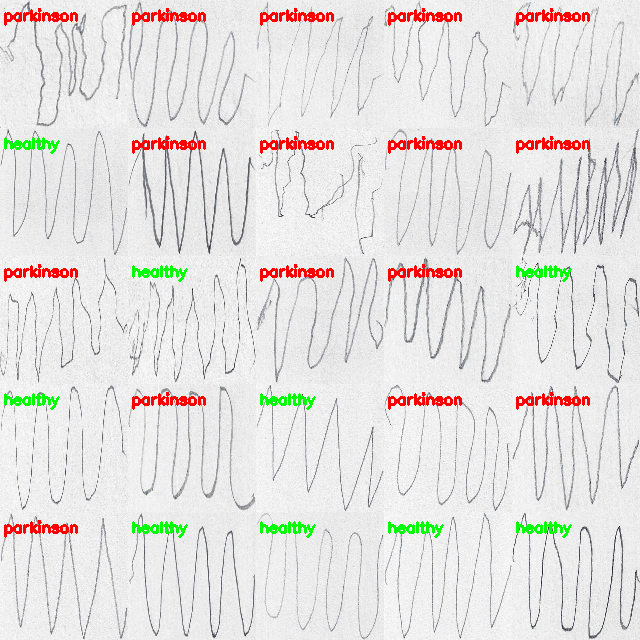

In [17]:
montage = build_montages(images, (128, 128), (5, 5))[0]

cv2_imshow(montage)

# Size 300, Method Hog

In [18]:
resize_image_size = 300
extraction_method = 'hog'

In [19]:
(feature_train, label_train) = load_split(trainingPath, image_size=resize_image_size, extraction_method=extraction_method)
(feature_test, label_test) = load_split(testingPath, image_size=resize_image_size, extraction_method=extraction_method)

print("Data loaded!")

Data loaded!


In [20]:
le = LabelEncoder()
label_train = le.fit_transform(label_train)
label_test = le.transform(label_test)

**Logistic Regression**

In [21]:
logreg = LogisticRegression()
logreg.fit(feature_train, label_train)
predictions = logreg.predict(feature_test)

classification_report(label_test, predictions)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(feature_test, label_test))) # .score() -> Accuracy
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

Accuracy of logistic regression classifier on test set: 0.70
F1 0.6996662958843158
Precision 0.7008928571428572
Recall 0.7


**LinearSVC**

In [22]:
classifier_lsvc = LinearSVC()
classifier_lsvc.fit(feature_train, label_train)
predictions = classifier_lsvc.predict(feature_test)

classification_report(label_test, predictions)
print('Accuracy of LinearSVC on test set: {:.2f}'.format(classifier_lsvc.score(feature_test, label_test)))
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

Accuracy of LinearSVC on test set: 0.73
F1 0.7321428571428572
Precision 0.7375565610859729
Recall 0.7333333333333334


**Random Forest**

In [23]:
model = RandomForestClassifier(n_estimators=100, random_state=10)
model.fit(feature_train, label_train)

predictions = model.predict(feature_test)

classification_report(label_test, predictions)

print(pd.crosstab(label_test, predictions, rownames=['True'], colnames=['Predicted'], margins=True))


Predicted   0   1  All
True                  
0          10   5   15
1           4  11   15
All        14  16   30


In [24]:
print(classification_report(label_test, predictions))

print('Accuracy of Random Forest on test set: {:.2f}'.format(model.score(feature_test, label_test)))
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

              precision    recall  f1-score   support

           0       0.71      0.67      0.69        15
           1       0.69      0.73      0.71        15

    accuracy                           0.70        30
   macro avg       0.70      0.70      0.70        30
weighted avg       0.70      0.70      0.70        30

Accuracy of Random Forest on test set: 0.70
F1 0.6996662958843158
Precision 0.7008928571428572
Recall 0.7


In [25]:
testing_paths = list(paths.list_images(testingPath))
images = []

for testing_path in testing_paths[:25]:
	image = cv.imread(testing_path)
	output = image.copy()
	output = cv.resize(output, (128, 128))

	image = preprocess(image, image_size=resize_image_size)

	if extraction_method == 'hog':
		features = quantify_image_hog(image)
	elif extraction_method == 'lbp':
		features = quantify_image_lbp(image)
   
	preds = classifier_lsvc.predict([features])
	label = le.inverse_transform(preds)[0]

	color = (0, 255, 0) if label == "healthy" else (0, 0, 255)
	cv.putText(output, label, (3, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
	images.append(output)

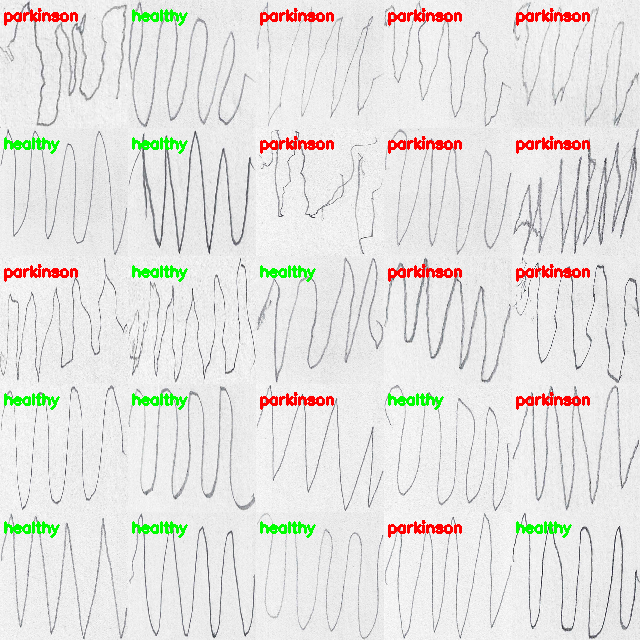

In [26]:
montage = build_montages(images, (128, 128), (5, 5))[0]

cv2_imshow(montage)

# Size 128 Method Lbp

In [27]:
resize_image_size = 128 # Masing-masing gambar perlu diresize menjadi suatu ukuran yang tetap # Berpengaruh terhadap evaluasi model
extraction_method = 'lbp' # 'lbp' atau 'hog'

In [28]:
(feature_train, label_train) = load_split(trainingPath, image_size=resize_image_size, extraction_method=extraction_method)
(feature_test, label_test) = load_split(testingPath, image_size=resize_image_size, extraction_method=extraction_method)

print("Data loaded!")

Data loaded!


In [29]:
le = LabelEncoder()
label_train = le.fit_transform(label_train)
label_test = le.transform(label_test)

**Logistic Regression**

In [30]:
logreg = LogisticRegression()
logreg.fit(feature_train, label_train)
predictions = logreg.predict(feature_test)

classification_report(label_test, predictions)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(feature_test, label_test))) # .score() -> Accuracy
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

Accuracy of logistic regression classifier on test set: 0.50
F1 0.4994438264738599
Precision 0.5
Recall 0.5


**LinearSVC**

In [31]:
classifier_lsvc = LinearSVC()
classifier_lsvc.fit(feature_train, label_train)
predictions = classifier_lsvc.predict(feature_test)

classification_report(label_test, predictions)
print('Accuracy of LinearSVC on test set: {:.2f}'.format(classifier_lsvc.score(feature_test, label_test)))
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

Accuracy of LinearSVC on test set: 0.57
F1 0.5622895622895623
Precision 0.5694444444444444
Recall 0.5666666666666667


**Random Forest**

In [32]:
model = RandomForestClassifier(n_estimators=100, random_state=10)
model.fit(feature_train, label_train)

predictions = model.predict(feature_test)

classification_report(label_test, predictions)

print(pd.crosstab(label_test, predictions, rownames=['True'], colnames=['Predicted'], margins=True))

Predicted   0   1  All
True                  
0           8   7   15
1           8   7   15
All        16  14   30


In [33]:
print(classification_report(label_test, predictions))

print('Accuracy of Random Forest on test set: {:.2f}'.format(model.score(feature_test, label_test)))
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

              precision    recall  f1-score   support

           0       0.50      0.53      0.52        15
           1       0.50      0.47      0.48        15

    accuracy                           0.50        30
   macro avg       0.50      0.50      0.50        30
weighted avg       0.50      0.50      0.50        30

Accuracy of Random Forest on test set: 0.50
F1 0.4994438264738599
Precision 0.5
Recall 0.5


In [34]:
testing_paths = list(paths.list_images(testingPath))
images = []

for testing_path in testing_paths[:25]:
	image = cv.imread(testing_path)
	output = image.copy()
	output = cv.resize(output, (128, 128))

	image = preprocess(image, image_size=resize_image_size)

	if extraction_method == 'hog':
		features = quantify_image_hog(image)
	elif extraction_method == 'lbp':
		features = quantify_image_lbp(image)
   
	preds = classifier_lsvc.predict([features])
	label = le.inverse_transform(preds)[0]

	color = (0, 255, 0) if label == "healthy" else (0, 0, 255)
	cv.putText(output, label, (3, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
	images.append(output)

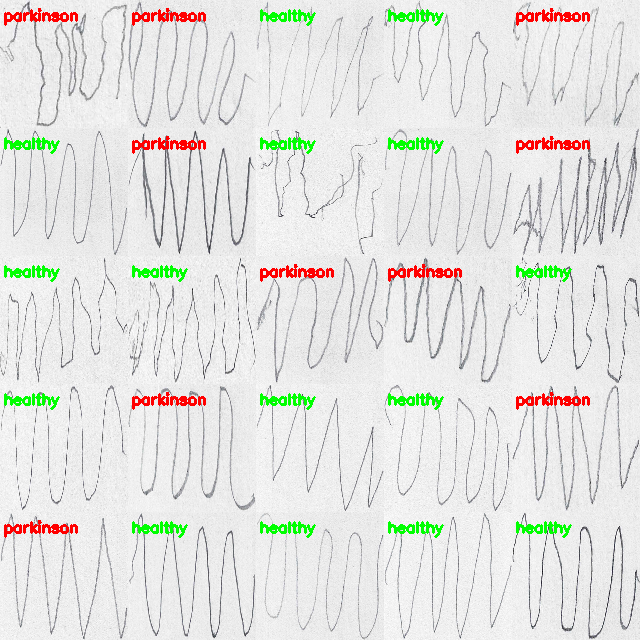

In [35]:
from imutils import build_montages

montage = build_montages(images, (128, 128), (5, 5))[0]

cv2_imshow(montage)

# Size 300 Method Lbp

In [36]:
resize_image_size = 300 # Masing-masing gambar perlu diresize menjadi suatu ukuran yang tetap # Berpengaruh terhadap evaluasi model
extraction_method = 'lbp' # 'lbp' atau 'hog'

In [37]:
(feature_train, label_train) = load_split(trainingPath, image_size=resize_image_size, extraction_method=extraction_method)
(feature_test, label_test) = load_split(testingPath, image_size=resize_image_size, extraction_method=extraction_method)

print("Data loaded!")

Data loaded!


In [38]:
le = LabelEncoder()
label_train = le.fit_transform(label_train)
label_test = le.transform(label_test)

**Logistic Regression**

In [39]:
logreg = LogisticRegression()
logreg.fit(feature_train, label_train)
predictions = logreg.predict(feature_test)

classification_report(label_test, predictions)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(feature_test, label_test))) # .score() -> Accuracy
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

Accuracy of logistic regression classifier on test set: 0.53
F1 0.5333333333333333
Precision 0.5333333333333333
Recall 0.5333333333333333


**LinearSVC**

In [40]:
classifier_lsvc = LinearSVC()
classifier_lsvc.fit(feature_train, label_train)
predictions = classifier_lsvc.predict(feature_test)

classification_report(label_test, predictions)
print('Accuracy of LinearSVC on test set: {:.2f}'.format(classifier_lsvc.score(feature_test, label_test)))
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

Accuracy of LinearSVC on test set: 0.53
F1 0.5333333333333333
Precision 0.5333333333333333
Recall 0.5333333333333333


**Random Forest**

In [41]:
model = RandomForestClassifier(n_estimators=100, random_state=10)
model.fit(feature_train, label_train)

predictions = model.predict(feature_test)

classification_report(label_test, predictions)

print(pd.crosstab(label_test, predictions, rownames=['True'], colnames=['Predicted'], margins=True))

Predicted   0   1  All
True                  
0           9   6   15
1           4  11   15
All        13  17   30


In [42]:
print(classification_report(label_test, predictions))

print('Accuracy of Random Forest on test set: {:.2f}'.format(model.score(feature_test, label_test)))
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

              precision    recall  f1-score   support

           0       0.69      0.60      0.64        15
           1       0.65      0.73      0.69        15

    accuracy                           0.67        30
   macro avg       0.67      0.67      0.67        30
weighted avg       0.67      0.67      0.67        30

Accuracy of Random Forest on test set: 0.67
F1 0.6651785714285714
Precision 0.6696832579185521
Recall 0.6666666666666666


In [43]:
testing_paths = list(paths.list_images(testingPath))
images = []

for testing_path in testing_paths[:25]:
	image = cv.imread(testing_path)
	output = image.copy()
	output = cv.resize(output, (128, 128))

	image = preprocess(image, image_size=resize_image_size)

	if extraction_method == 'hog':
		features = quantify_image_hog(image)
	elif extraction_method == 'lbp':
		features = quantify_image_lbp(image)
   
	preds = model.predict([features])
	label = le.inverse_transform(preds)[0]

	color = (0, 255, 0) if label == "healthy" else (0, 0, 255)
	cv.putText(output, label, (3, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
	images.append(output)

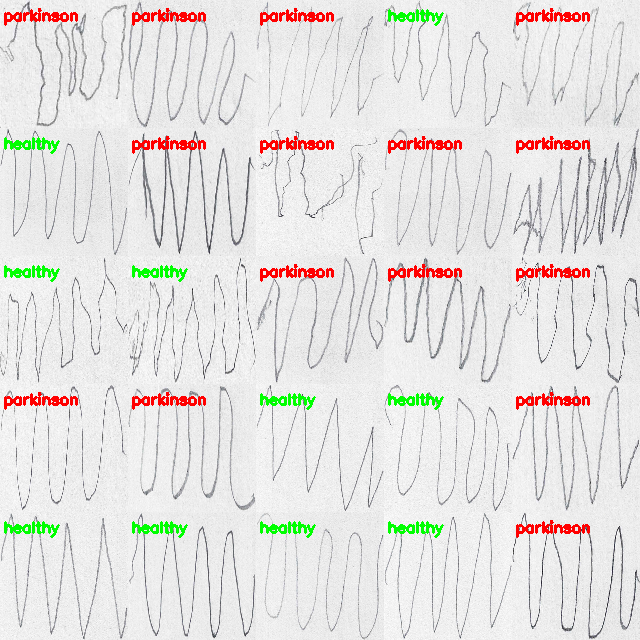

In [44]:
montage = build_montages(images, (128, 128), (5, 5))[0]

cv2_imshow(montage)

# Kesimpulan

Akurasi dan F1 Score terbaik didapatkan dengan Linear SVC, jika method preprocessing menggunakan Hog dan ukuran image 300. Dengan hasil:

Accuracy of LinearSVC on test set: 0.73

F1 0.7321428571428572

Precision 0.7375565610859729

Recall 0.7333333333333334


Dan didapatkan score yang sama dengan Random Forest, jika method preprocessing menggunakan Hog dan ukuran image 128. Dengan hasil:

Accuracy of Random Forest on test set: 0.73

F1 0.7321428571428572

Precision 0.7375565610859729

Recall 0.7333333333333334

# Jawaban 2

**Penambahan 15 gambar wave pada training healthy dan parkinson**

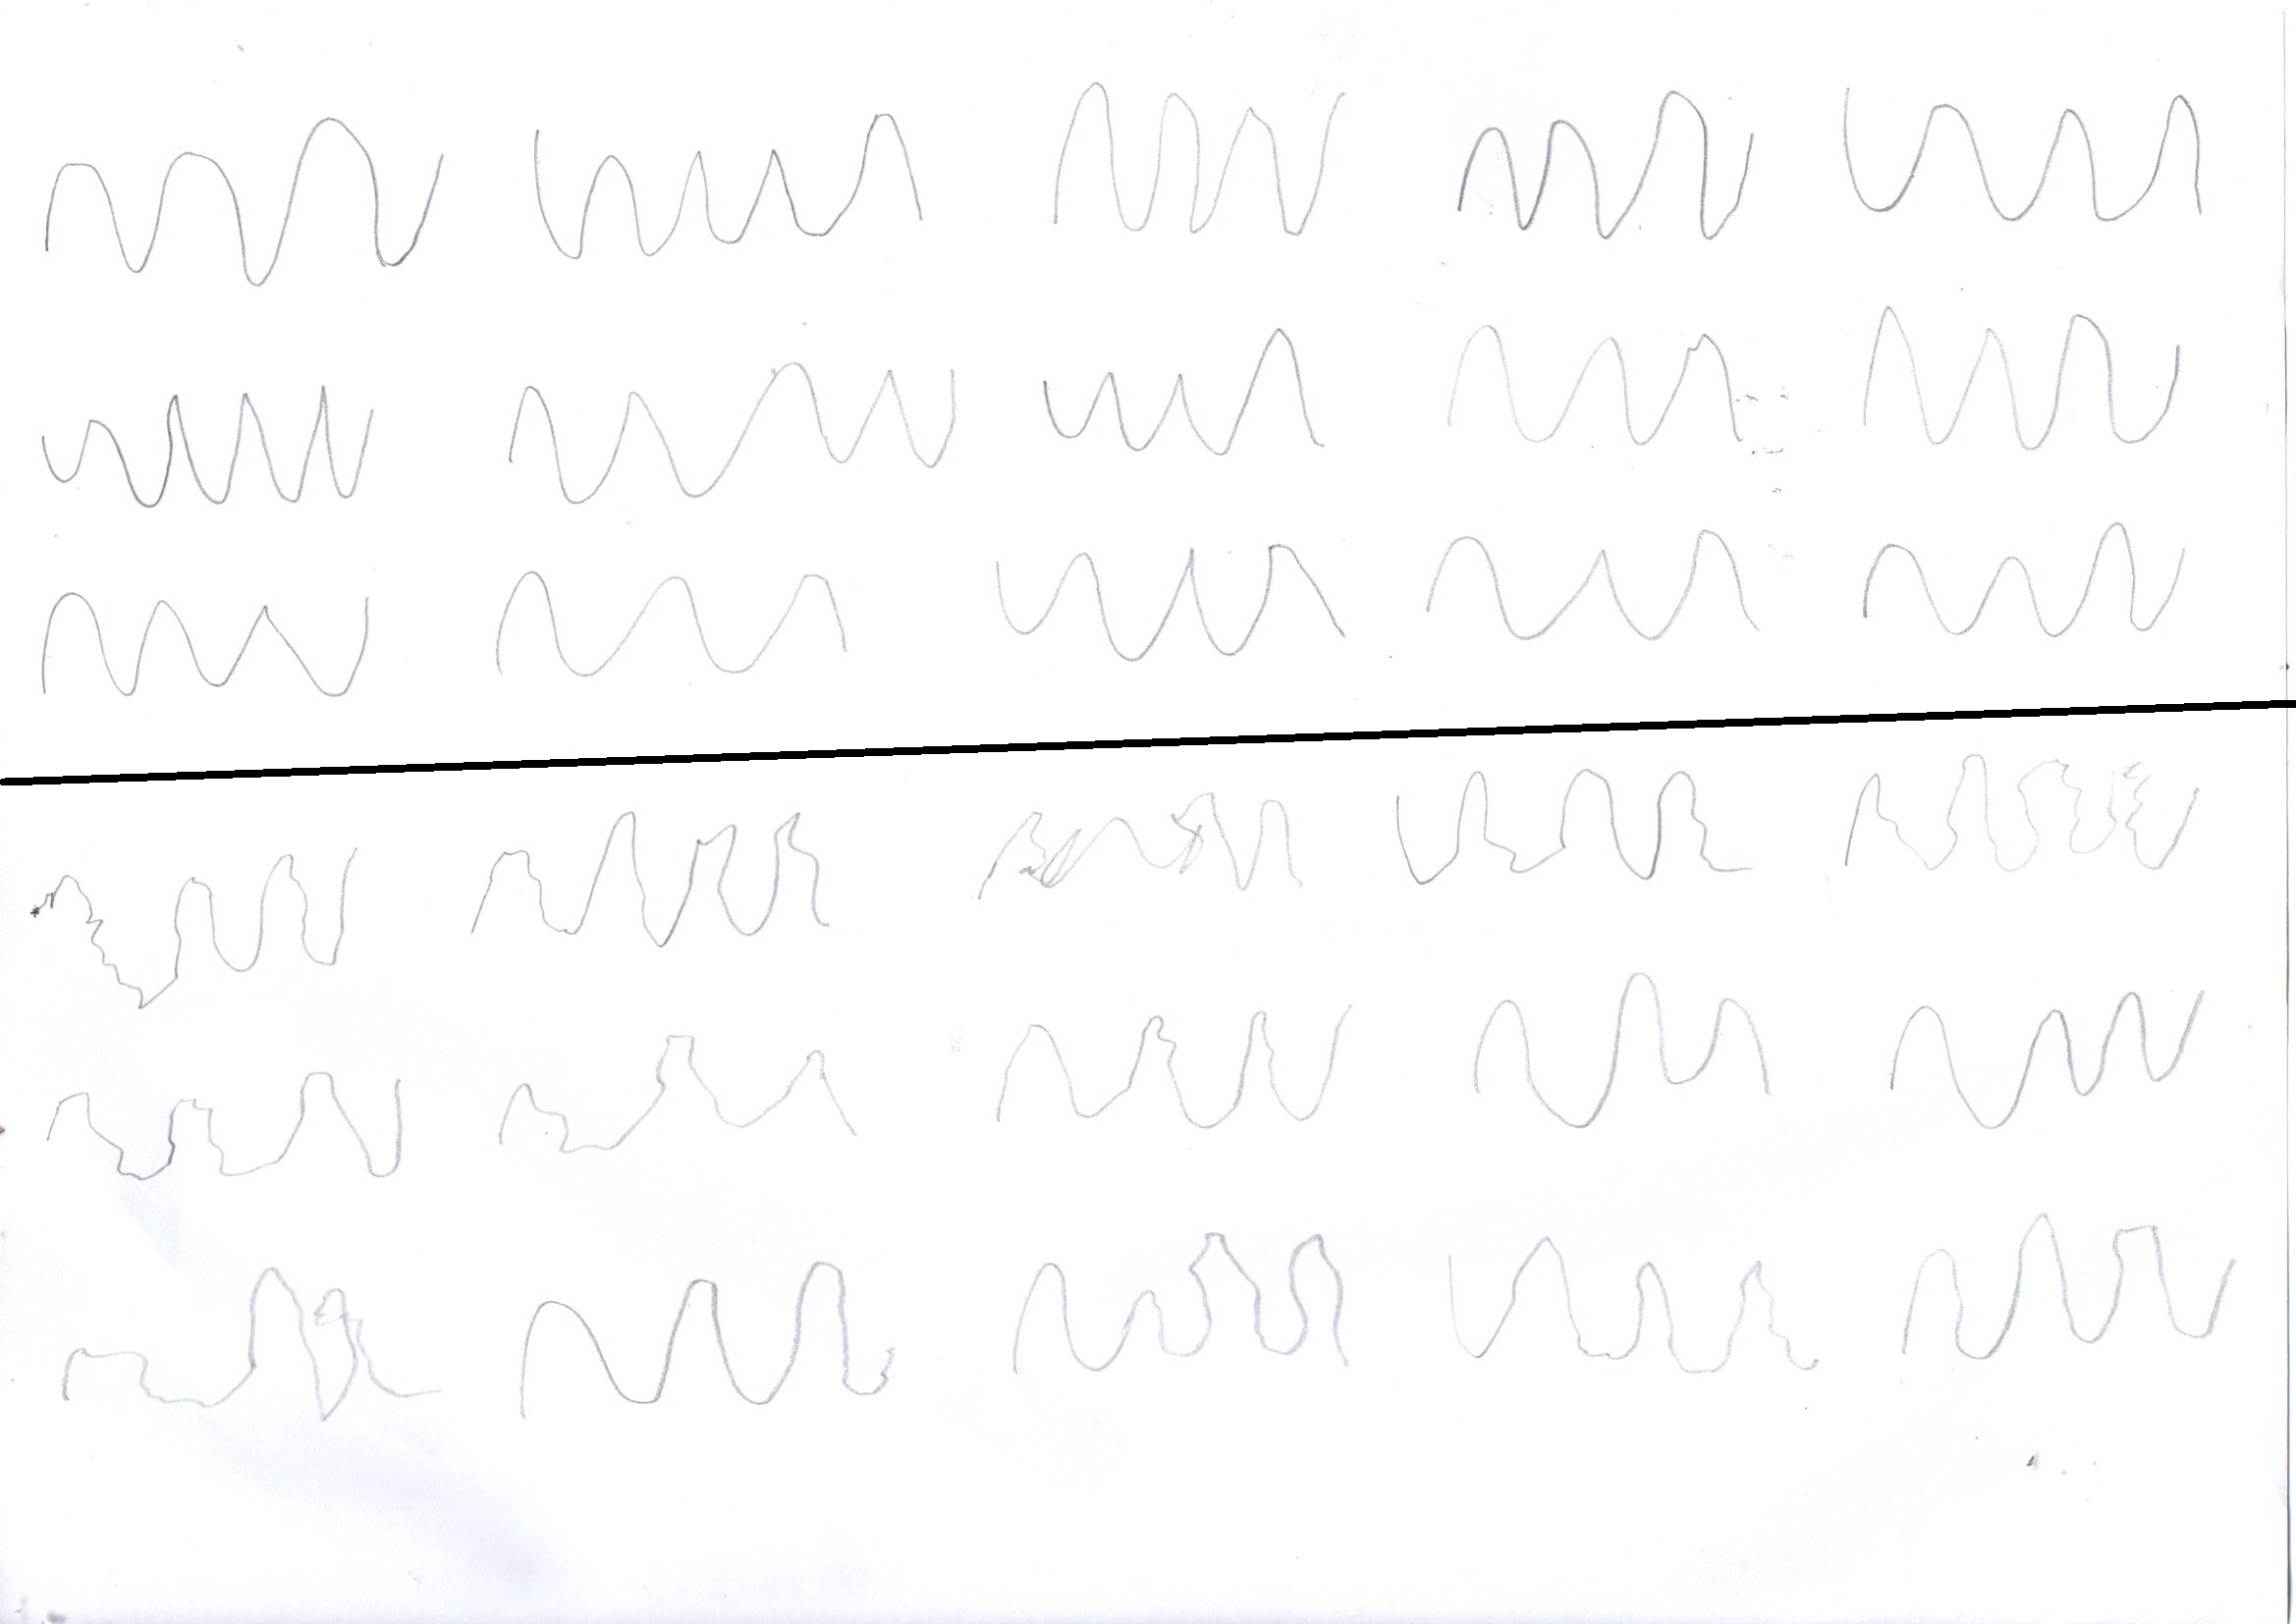

# Size 128, Method Hog

In [45]:
dataset_dir = '/content/drive/My Drive/BCML/CV/wave'

trainingPath = os.path.join(dataset_dir, "training_ext")
testingPath = os.path.join(dataset_dir, "testing")

In [58]:
resize_image_size = 128
extraction_method = 'hog'

In [59]:
(feature_train, label_train) = load_split(trainingPath, image_size=resize_image_size, extraction_method=extraction_method)
(feature_test, label_test) = load_split(testingPath, image_size=resize_image_size, extraction_method=extraction_method)

print("Data loaded!")

Data loaded!


In [60]:
le = LabelEncoder()
label_train = le.fit_transform(label_train)
label_test = le.transform(label_test)

**LinearSVC**

In [61]:
classifier_lsvc = LinearSVC()
classifier_lsvc.fit(feature_train, label_train)
predictions = classifier_lsvc.predict(feature_test)

classification_report(label_test, predictions)
print('Accuracy of LinearSVC on test set: {:.2f}'.format(classifier_lsvc.score(feature_test, label_test)))
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

Accuracy of LinearSVC on test set: 0.67
F1 0.6651785714285714
Precision 0.6696832579185521
Recall 0.6666666666666666


**Random Forest**

In [62]:
model = RandomForestClassifier(n_estimators=100, random_state=10)
model.fit(feature_train, label_train)

predictions = model.predict(feature_test)

classification_report(label_test, predictions)

print(pd.crosstab(label_test, predictions, rownames=['True'], colnames=['Predicted'], margins=True))

Predicted   0   1  All
True                  
0           9   6   15
1           5  10   15
All        14  16   30


In [63]:
print(classification_report(label_test, predictions))

print('Accuracy of Random Forest on test set: {:.2f}'.format(model.score(feature_test, label_test)))
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

              precision    recall  f1-score   support

           0       0.64      0.60      0.62        15
           1       0.62      0.67      0.65        15

    accuracy                           0.63        30
   macro avg       0.63      0.63      0.63        30
weighted avg       0.63      0.63      0.63        30

Accuracy of Random Forest on test set: 0.63
F1 0.6329254727474972
Precision 0.6339285714285714
Recall 0.6333333333333333


In [64]:
testing_paths = list(paths.list_images(testingPath))
images = []

for testing_path in testing_paths[:25]:
	image = cv.imread(testing_path)
	output = image.copy()
	output = cv.resize(output, (128, 128))

	image = preprocess(image, image_size=resize_image_size)

	if extraction_method == 'hog':
		features = quantify_image_hog(image)
	elif extraction_method == 'lbp':
		features = quantify_image_lbp(image)
   
	preds = classifier_lsvc.predict([features])
	label = le.inverse_transform(preds)[0]

	color = (0, 255, 0) if label == "healthy" else (0, 0, 255)
	cv.putText(output, label, (3, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
	images.append(output)

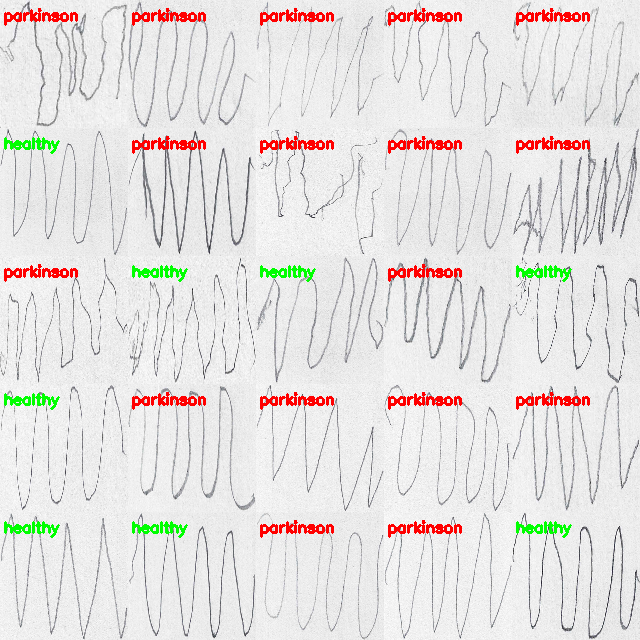

In [65]:
montage = build_montages(images, (128, 128), (5, 5))[0]

cv2_imshow(montage)

# Size 300, Method Hog

In [66]:
resize_image_size = 300
extraction_method = 'hog'

In [67]:
(feature_train, label_train) = load_split(trainingPath, image_size=resize_image_size, extraction_method=extraction_method)
(feature_test, label_test) = load_split(testingPath, image_size=resize_image_size, extraction_method=extraction_method)

print("Data loaded!")

Data loaded!


In [68]:
le = LabelEncoder()
label_train = le.fit_transform(label_train)
label_test = le.transform(label_test)

In [69]:
classifier_lsvc = LinearSVC()
classifier_lsvc.fit(feature_train, label_train)
predictions = classifier_lsvc.predict(feature_test)

classification_report(label_test, predictions)
print('Accuracy of LinearSVC on test set: {:.2f}'.format(classifier_lsvc.score(feature_test, label_test)))
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

Accuracy of LinearSVC on test set: 0.70
F1 0.6996662958843158
Precision 0.7008928571428572
Recall 0.7


In [70]:
model = RandomForestClassifier(n_estimators=100, random_state=10)
model.fit(feature_train, label_train)

predictions = model.predict(feature_test)

classification_report(label_test, predictions)

print(pd.crosstab(label_test, predictions, rownames=['True'], colnames=['Predicted'], margins=True))

Predicted   0   1  All
True                  
0          10   5   15
1           5  10   15
All        15  15   30


In [71]:
print(classification_report(label_test, predictions))

print('Accuracy of Random Forest on test set: {:.2f}'.format(model.score(feature_test, label_test)))
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.67      0.67      0.67        15

    accuracy                           0.67        30
   macro avg       0.67      0.67      0.67        30
weighted avg       0.67      0.67      0.67        30

Accuracy of Random Forest on test set: 0.67
F1 0.6666666666666666
Precision 0.6666666666666666
Recall 0.6666666666666666


In [74]:
testing_paths = list(paths.list_images(testingPath))
images = []

for testing_path in testing_paths[:25]:
	image = cv.imread(testing_path)
	output = image.copy()
	output = cv.resize(output, (128, 128))

	image = preprocess(image, image_size=resize_image_size)

	if extraction_method == 'hog':
		features = quantify_image_hog(image)
	elif extraction_method == 'lbp':
		features = quantify_image_lbp(image)
   
	preds = classifier_lsvc.predict([features])
	label = le.inverse_transform(preds)[0]

	color = (0, 255, 0) if label == "healthy" else (0, 0, 255)
	cv.putText(output, label, (3, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
	images.append(output)

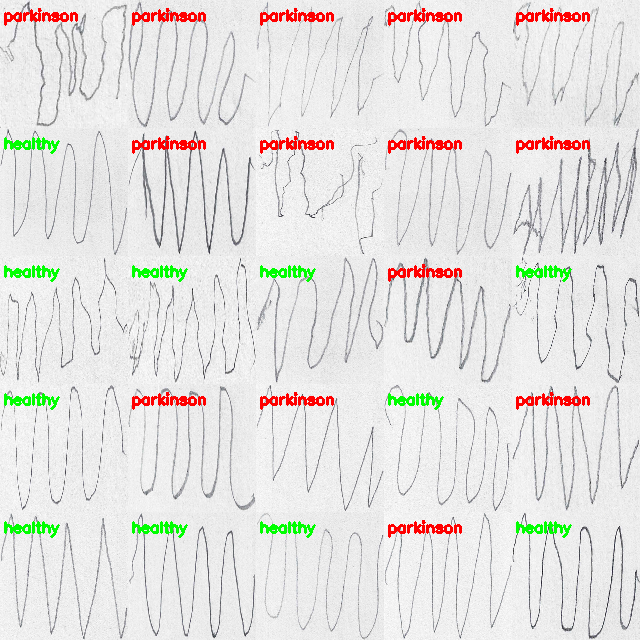

In [75]:
montage = build_montages(images, (128, 128), (5, 5))[0]

cv2_imshow(montage)

# Kesimpulan

Setelah dilakukan penambahan gambar untuk training dengan model terbaik pada kasus ini berkurang akurasinya. Akan tetapi setelah penggunaan size 128 dan 300 kembali masing-masing score paling tinggi didapatkan oleh LinearSVC. Dan yang paling tinggi menggunakan size 300 dan method Hog. Dimana didapatkan :

Accuracy of LinearSVC on test set: 0.70

F1 0.6996662958843158

Precision 0.7008928571428572

Recall 0.7